# <font color='orange'>Step 2: Data Understanding</font> 

In [4]:
# Pandas DF operation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import array
#pyspark
import pyspark
from pyspark.sql import SparkSession
import warnings
warnings.simplefilter(action='ignore')
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType, StringType, DoubleType, ShortType, DecimalType
import pyspark.sql.functions as func
from pyspark.sql.functions import isnull
from pyspark.sql.functions import isnan, when, count, col, round
from pyspark.sql.functions import mean
from pyspark.sql.types import Row
import matplotlib.pyplot as plt
from pyspark.sql.functions import udf



# Modeling + Evaluation
from pyspark.ml.feature import VectorAssembler, VectorIndexer, OneHotEncoder, StringIndexer
from pyspark.sql.functions import when
from pyspark.sql import functions as F
from pyspark.sql.functions import avg
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder 
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import log_loss
from pyspark.sql import Window
from pyspark.sql.functions import rank,sum,col
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorSlicer

In [5]:
# Build a sparksession and build a unique app name
spark=SparkSession.builder.appName('iteration-4: prediction_hospital_readmission_rate ').getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/10/11 20:49:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:
from pyspark import SparkContext
sc = SparkContext.getOrCreate()

## <font color='grey'> 2.1: Collect Initial Data</font> 

In [7]:
# Read the data from csv file into a dataframe
diabetic_data=spark.read.option("header","true").csv('Dataset/diabetic_data.csv')

## <font color='grey'> 2.2: Data Description</font> 

In [8]:
diabetic_data.show(1)

22/10/11 20:51:45 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+------------+-----------+---------+------+------+------+-----------------+------------------------+-------------------+----------------+----------+--------------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+------+------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+----------+
|encounter_id|patient_nbr|     race|gender|   age|weight|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|payer_code|   medical_specialty|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|diag_1|diag_2|diag_3|number_diagnoses|max_glu_ser

## <font color='grey'> 2.3: Explore the Data</font> 

In [9]:
# Check number of rows and columns in the data
row=diabetic_data.count()
cols=len(diabetic_data.columns)
print('Total number of columns are - ', cols)
print('\nTotal number of records are - ', row)

Total number of columns are -  50

Total number of records are -  101766


In [10]:
diabetic_data.select('readmitted').groupBy('readmitted').count().sort(col('count').asc()).show()

+----------+-----+
|readmitted|count|
+----------+-----+
|       <30|11357|
|       >30|35545|
|        NO|54864|
+----------+-----+



In [11]:
diabetic_data.printSchema()

root
 |-- encounter_id: string (nullable = true)
 |-- patient_nbr: string (nullable = true)
 |-- race: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: string (nullable = true)
 |-- weight: string (nullable = true)
 |-- admission_type_id: string (nullable = true)
 |-- discharge_disposition_id: string (nullable = true)
 |-- admission_source_id: string (nullable = true)
 |-- time_in_hospital: string (nullable = true)
 |-- payer_code: string (nullable = true)
 |-- medical_specialty: string (nullable = true)
 |-- num_lab_procedures: string (nullable = true)
 |-- num_procedures: string (nullable = true)
 |-- num_medications: string (nullable = true)
 |-- number_outpatient: string (nullable = true)
 |-- number_emergency: string (nullable = true)
 |-- number_inpatient: string (nullable = true)
 |-- diag_1: string (nullable = true)
 |-- diag_2: string (nullable = true)
 |-- diag_3: string (nullable = true)
 |-- number_diagnoses: string (nullable = true)
 |-- max_glu_ser

In [12]:
# Let's import in the relevant types.
from pyspark.sql.types import (StructField,StringType,IntegerType,StructType,FloatType)



In [1]:
# diabetic_data.columns

In [13]:
# Then create a variable with the correct structure.
data_schema = [StructField('encounter_id',IntegerType(),True),
              StructField('patient_nbr',IntegerType(),True),
              StructField('race',StringType(),True),
              StructField('gender',StringType(),True),
              StructField('age',StringType(),True),
              StructField('weight',StringType(),True),
              StructField('admission_type_id',IntegerType(),True),
              StructField('discharge_disposition_id',IntegerType(),True),
              StructField('admission_source_id',IntegerType(),True),
              StructField('time_in_hospital',IntegerType(),True),
              StructField('payer_code',StringType(),True),
              StructField('medical_specialty',StringType(),True),
              StructField('num_lab_procedures',IntegerType(),True),
              StructField('num_procedures',IntegerType(),True),
              StructField('num_medications',IntegerType(),True),
              StructField('number_outpatient',IntegerType(),True),
              StructField('number_emergency',IntegerType(),True),
              StructField('number_inpatient',IntegerType(),True),
              StructField('diag_1',StringType(),True),
              StructField('diag_2',StringType(),True),
              StructField('diag_3',StringType(),True),
              StructField('number_diagnoses',IntegerType(),True),
              StructField('max_glu_serum',StringType(),True),
              StructField('A1Cresult',StringType(),True),
              StructField('metformin',StringType(),True),
              StructField('repaglinide',StringType(),True),
              StructField('nateglinide',StringType(),True),
              StructField('chlorpropamide',StringType(),True),
              StructField('glimepiride',StringType(),True),
              StructField('acetohexamide',StringType(),True),
              StructField('glipizide',StringType(),True),
              StructField('glyburide',StringType(),True),
              StructField('tolbutamide',StringType(),True),
              StructField('pioglitazone',StringType(),True),
              StructField('rosiglitazone',StringType(),True),
              StructField('acarbose',StringType(),True),
              StructField('miglitol',StringType(),True),
              StructField('troglitazone',StringType(),True),
              StructField('tolazamide',StringType(),True),
              StructField('examide',StringType(),True),
              StructField('citoglipton',StringType(),True),
              StructField('insulin',StringType(),True),
              StructField('glyburide-metformin',StringType(),True),
              StructField('glipizide-metformin',StringType(),True),
              StructField('glimepiride-pioglitazone',StringType(),True),
              StructField('metformin-rosiglitazone',StringType(),True),
              StructField('metformin-pioglitazone',StringType(),True),
              StructField('change',StringType(),True),
              StructField('diabetesMed',StringType(),True),
              StructField('readmitted',StringType(),True)]

final_struct = StructType(fields=data_schema)

In [14]:
diabetic_data=spark.read.option("header","true").csv('Dataset/diabetic_data.csv',schema=final_struct)

In [15]:
diabetic_data.printSchema()

root
 |-- encounter_id: integer (nullable = true)
 |-- patient_nbr: integer (nullable = true)
 |-- race: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: string (nullable = true)
 |-- weight: string (nullable = true)
 |-- admission_type_id: integer (nullable = true)
 |-- discharge_disposition_id: integer (nullable = true)
 |-- admission_source_id: integer (nullable = true)
 |-- time_in_hospital: integer (nullable = true)
 |-- payer_code: string (nullable = true)
 |-- medical_specialty: string (nullable = true)
 |-- num_lab_procedures: integer (nullable = true)
 |-- num_procedures: integer (nullable = true)
 |-- num_medications: integer (nullable = true)
 |-- number_outpatient: integer (nullable = true)
 |-- number_emergency: integer (nullable = true)
 |-- number_inpatient: integer (nullable = true)
 |-- diag_1: string (nullable = true)
 |-- diag_2: string (nullable = true)
 |-- diag_3: string (nullable = true)
 |-- number_diagnoses: integer (nullable = true)
 |-

In [16]:
# Seperate two object for continuous and categorical data
numeric_columns = [column[0] for column in diabetic_data.dtypes if column[1]=='int']
categorical_data=[column[0] for column in diabetic_data.dtypes if column[1]=='string']

## Pyspark SQL

In [17]:
# First, we have to register the DataFrame as a SQL temporary view.
diabetic_data.createOrReplaceTempView('diabetic_data')

# After that, we can use the SQL programming language for queries. 
results = spark.sql("SELECT * FROM diabetic_data")
results.show()

+------------+-----------+---------------+------+--------+------+-----------------+------------------------+-------------------+----------------+----------+--------------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+------+------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+----------+
|encounter_id|patient_nbr|           race|gender|     age|weight|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|payer_code|   medical_specialty|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|diag_1|diag_2|diag_3|number_diagn

In [18]:
spark.sql("select distinct race from diabetic_data").show()

+---------------+
|           race|
+---------------+
|      Caucasian|
|          Other|
|AfricanAmerican|
|       Hispanic|
|          Asian|
|              ?|
+---------------+



In [19]:
spark.sql("select distinct gender from diabetic_data").show()

+---------------+
|         gender|
+---------------+
|         Female|
|Unknown/Invalid|
|           Male|
+---------------+



In [20]:
diabetic_data.select('gender').toPandas().value_counts()

gender         
Female             54708
Male               47055
Unknown/Invalid        3
dtype: int64

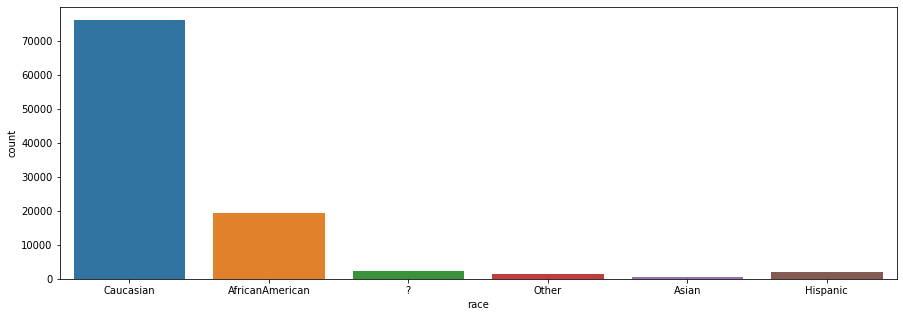

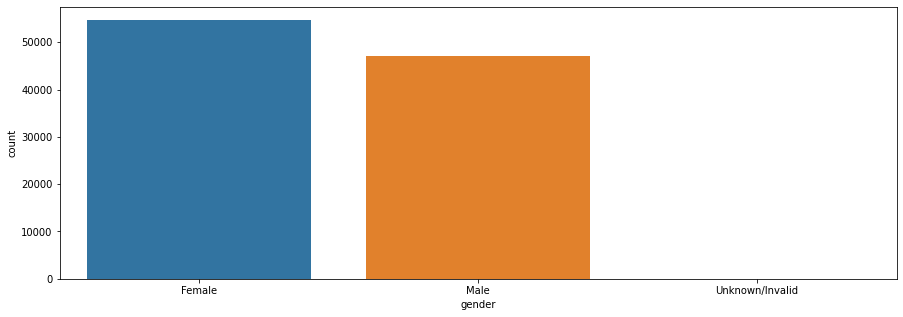

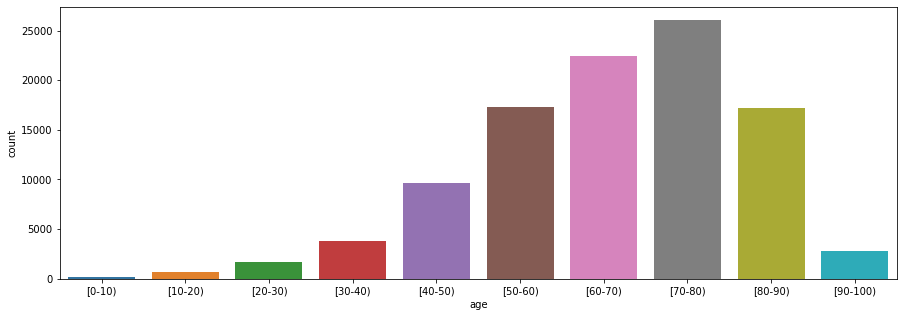

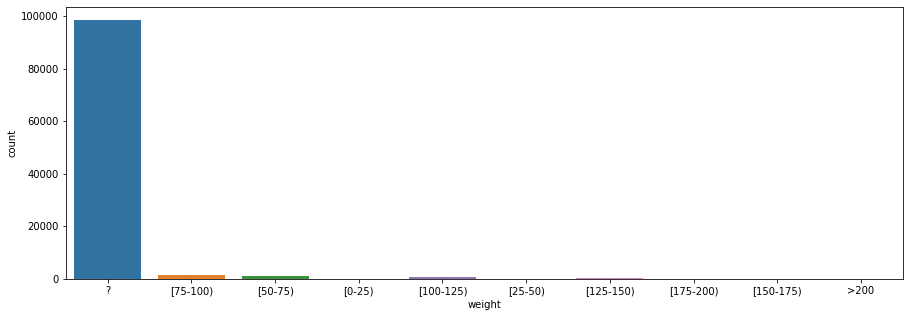

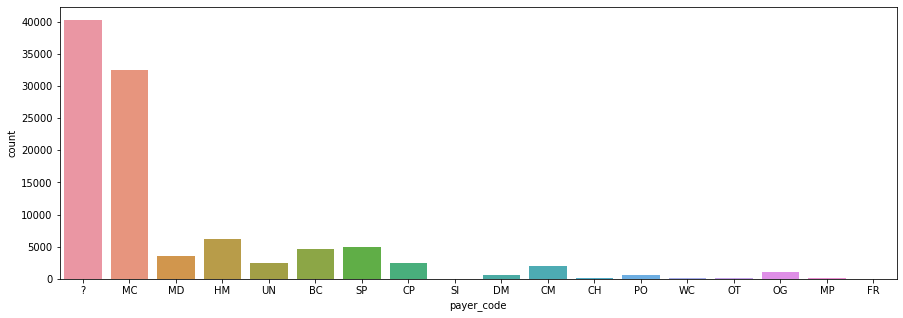

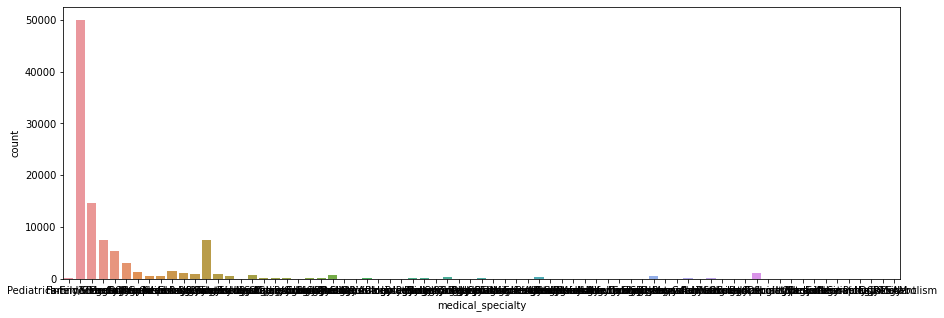

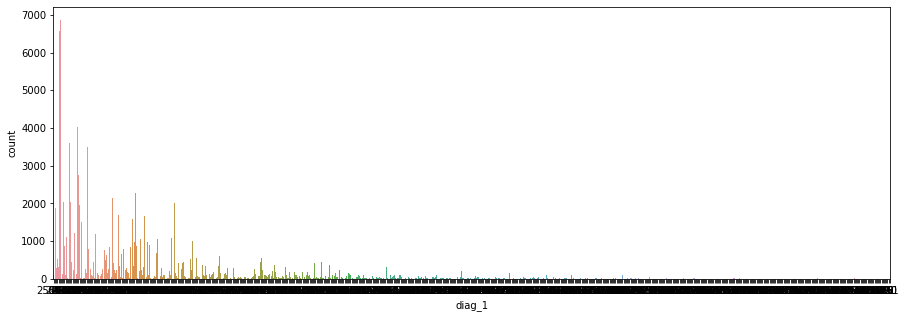

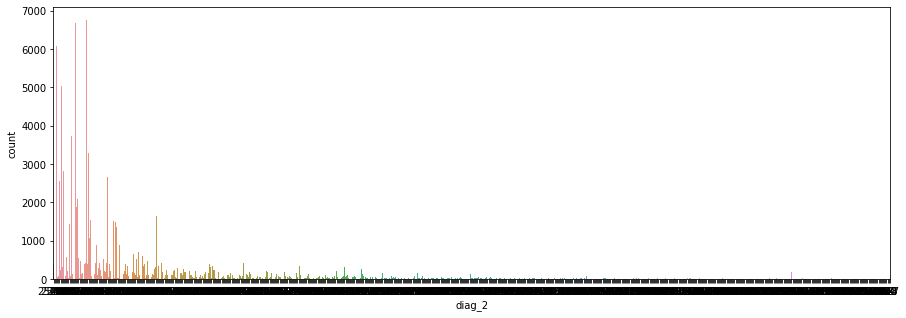

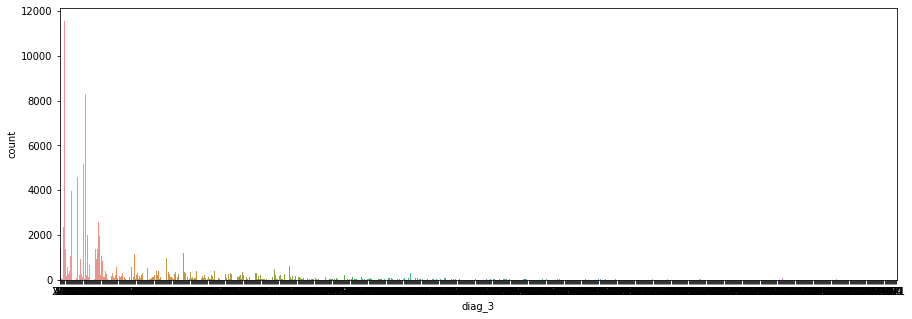

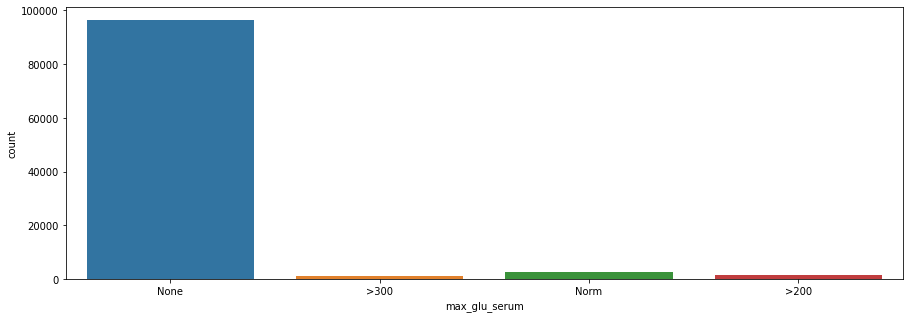

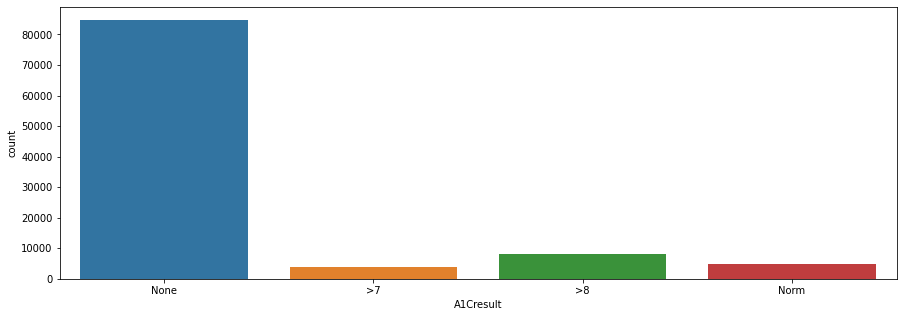

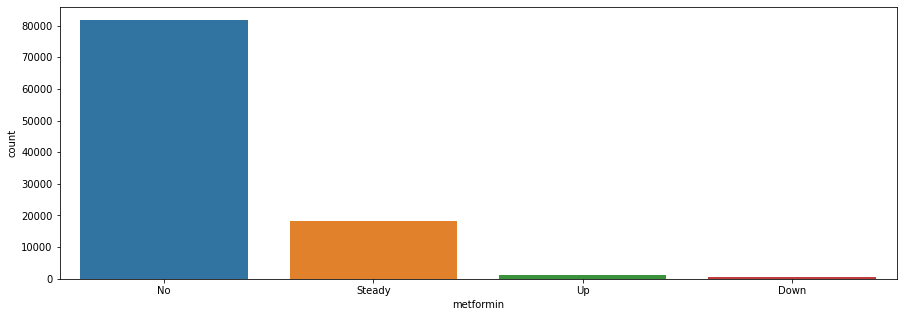

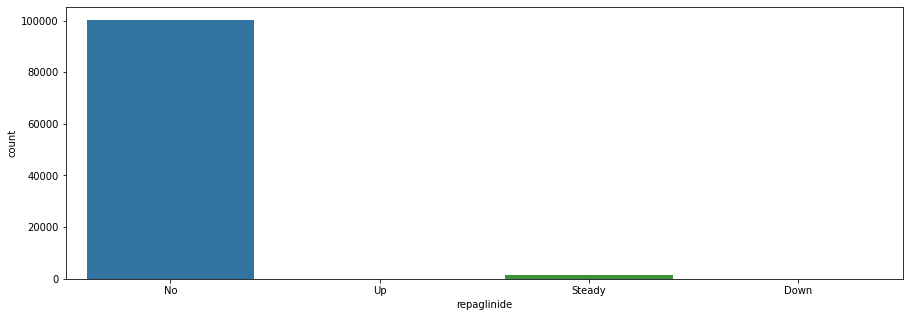

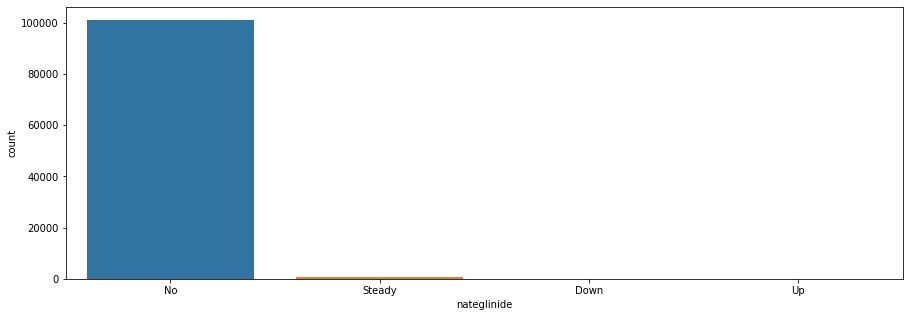

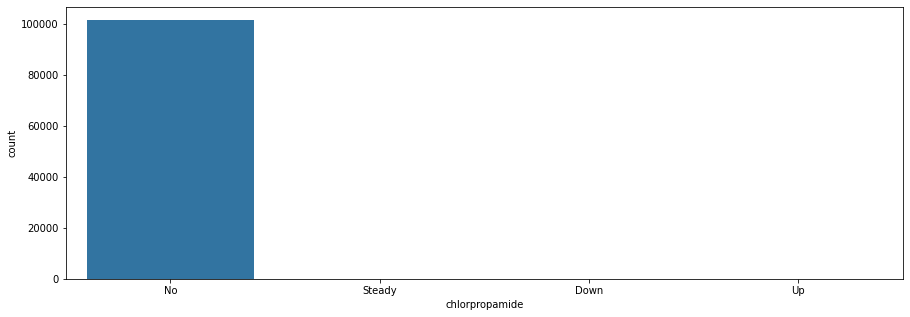

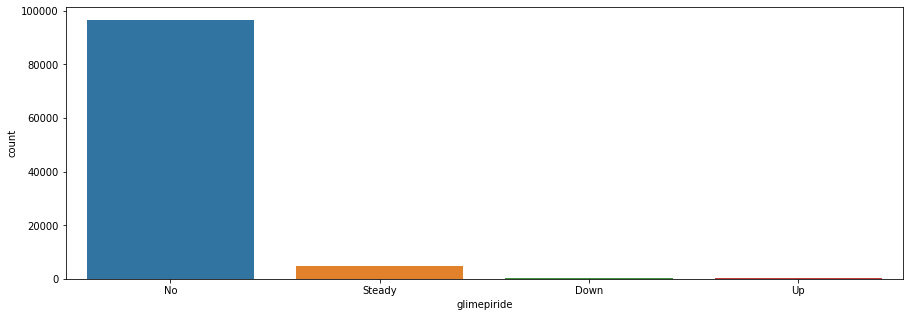

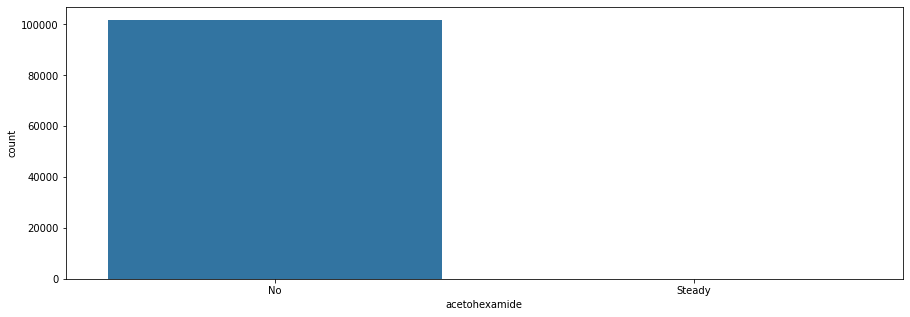

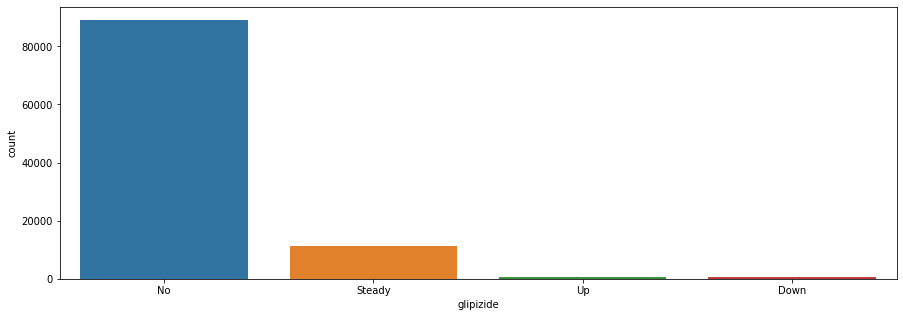

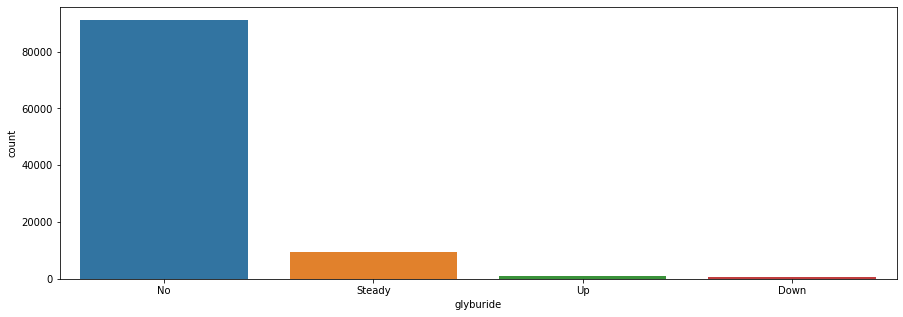

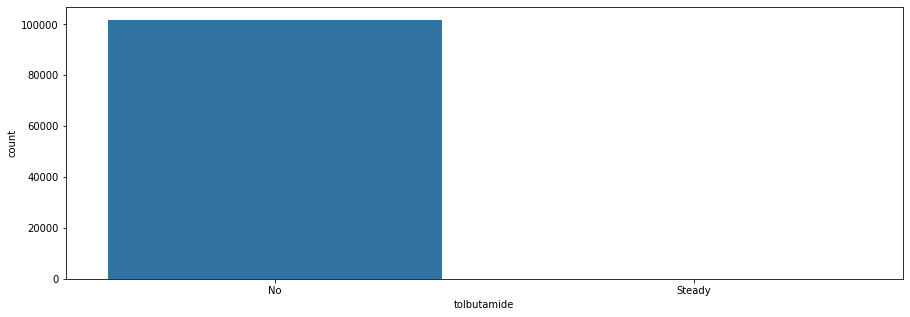

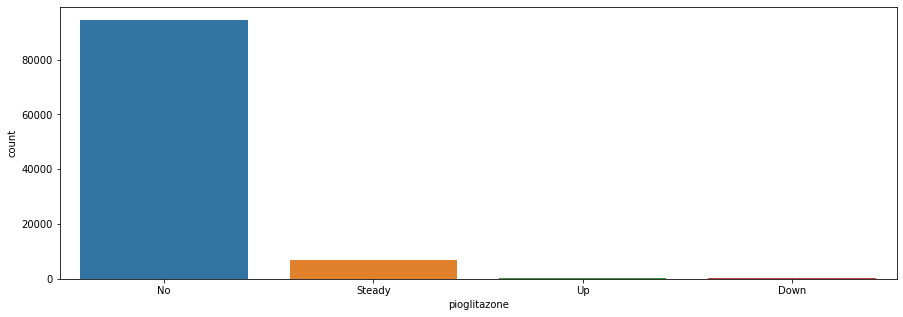

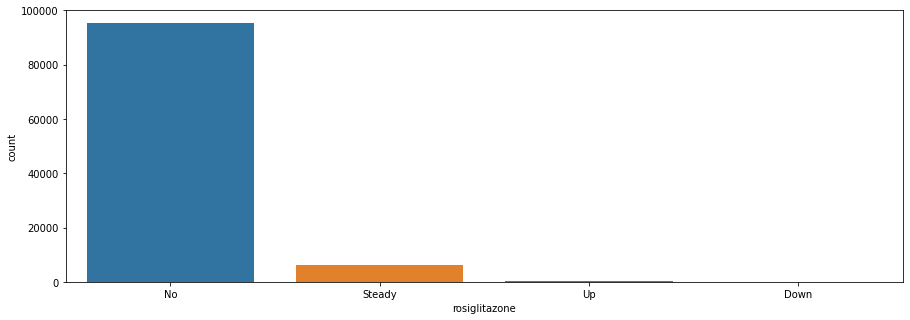

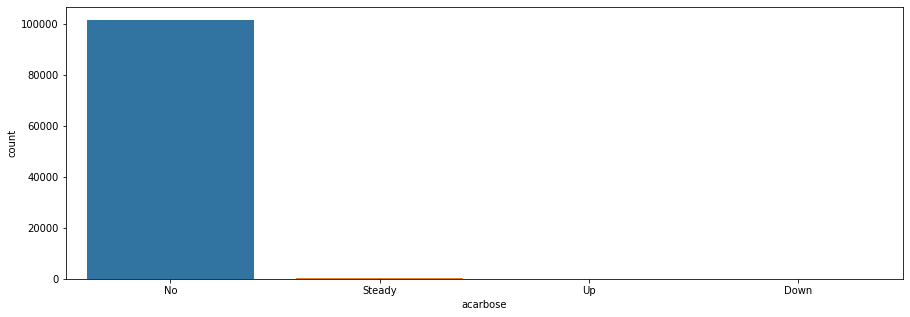

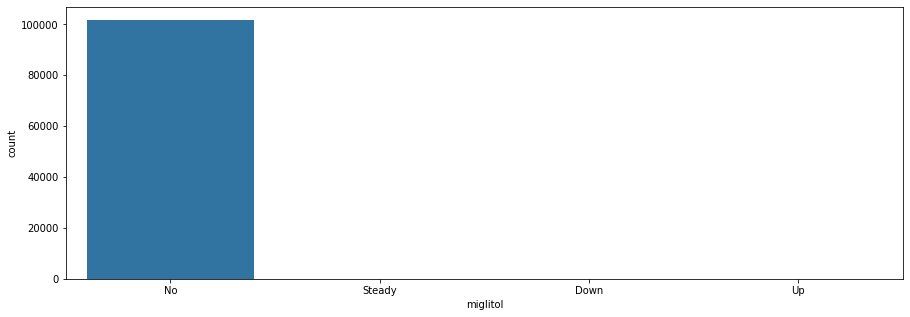

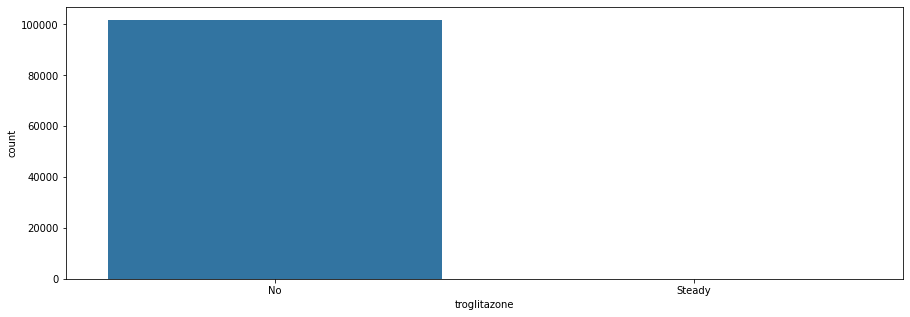

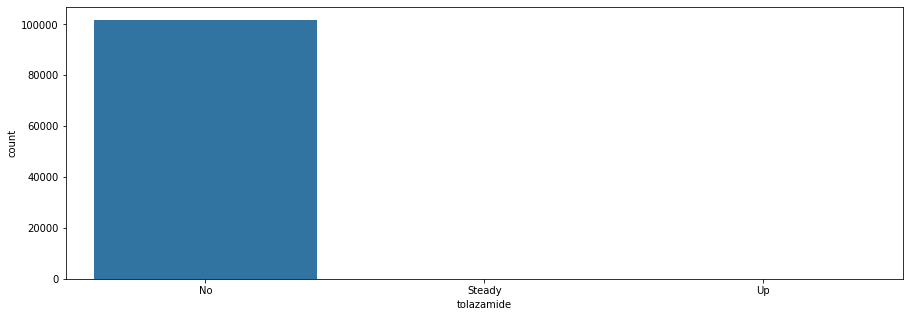

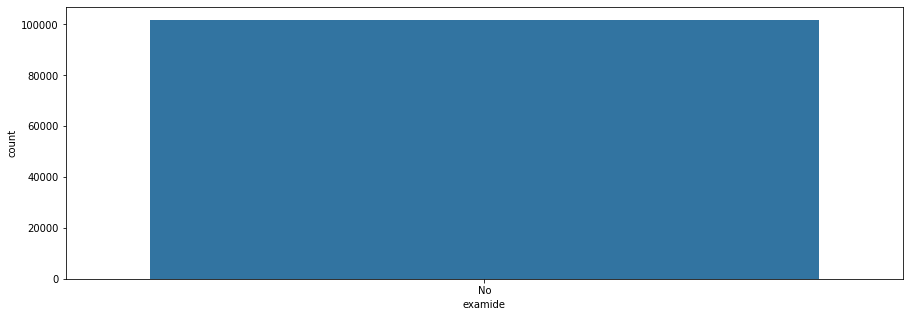

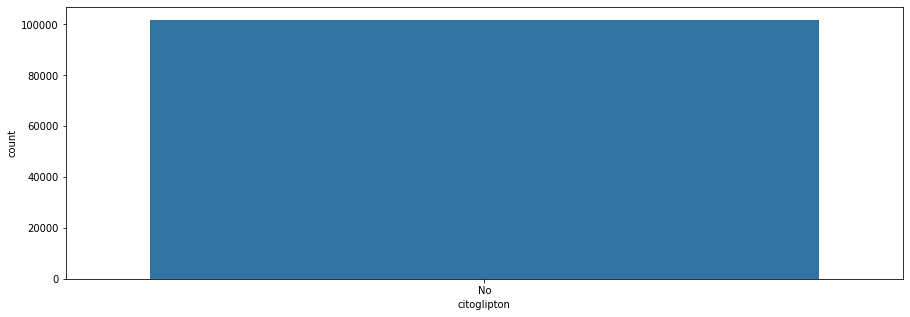

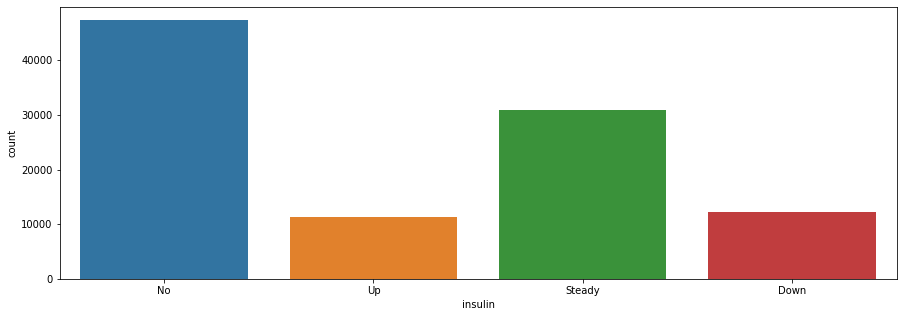

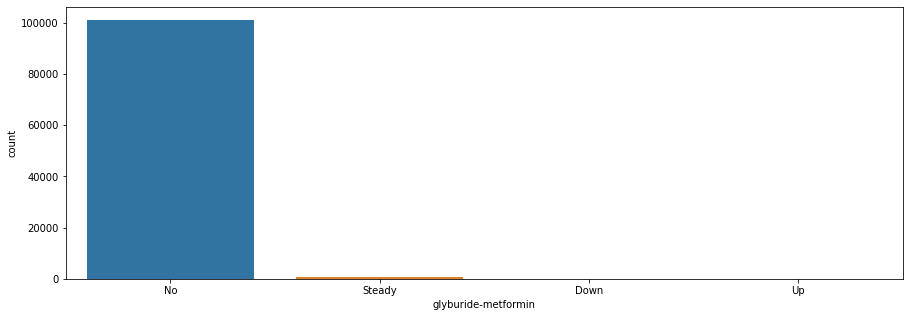

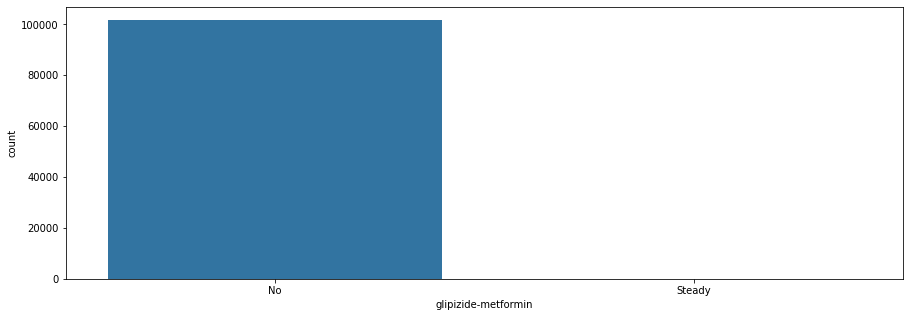

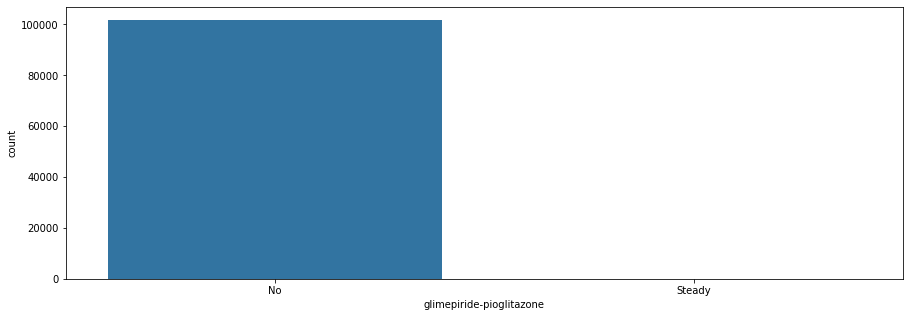

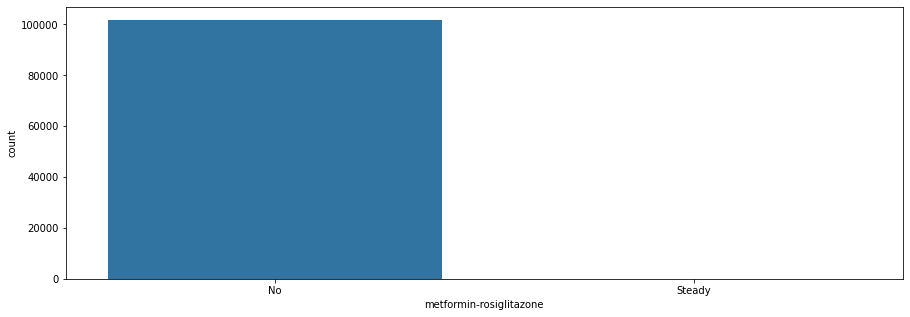

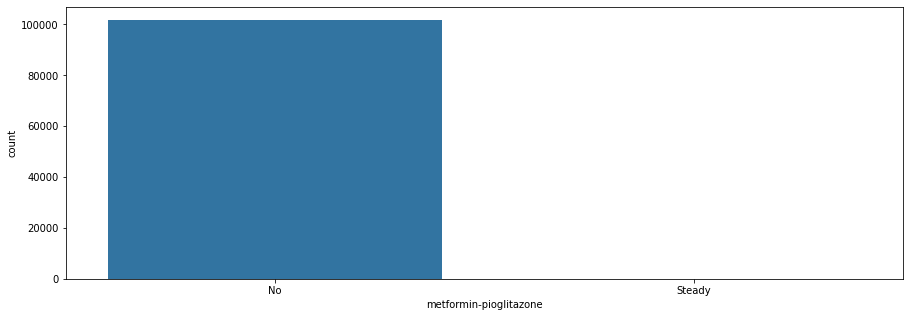

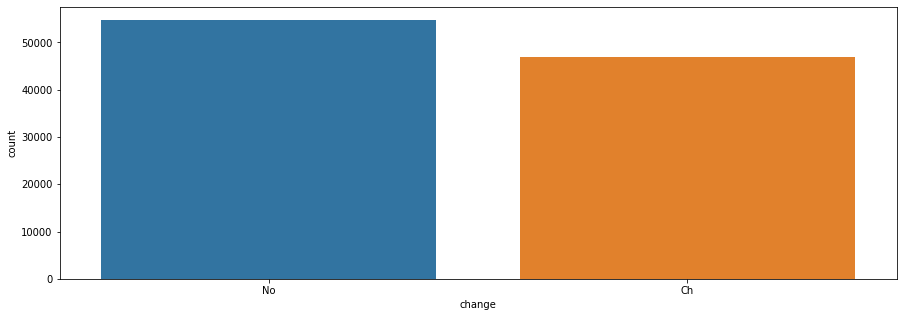

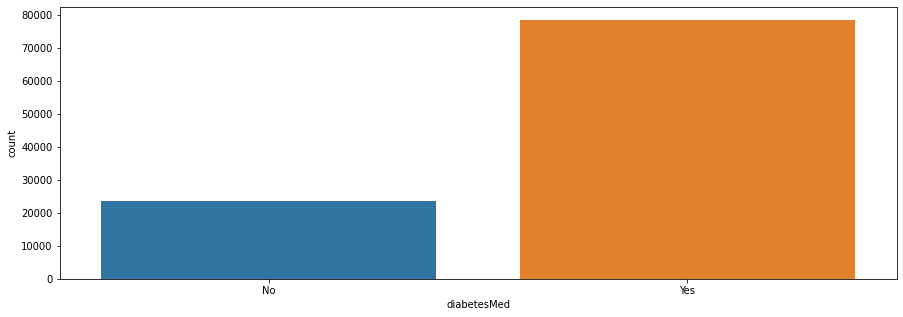

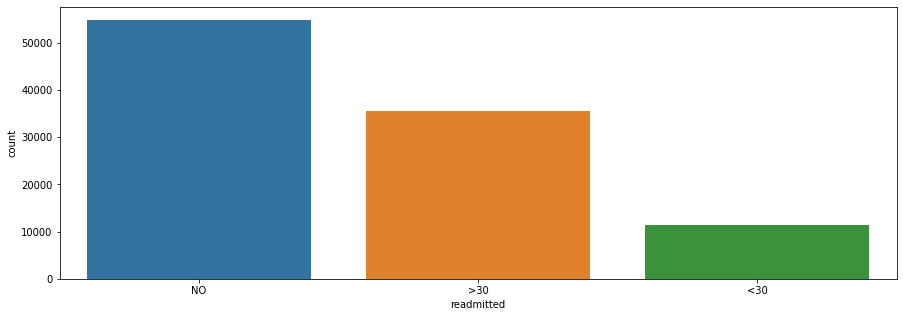

In [22]:
def countplot(df):
    for col in categorical_data:
        plt.figure(figsize=(15,5))
        sns.countplot(data=(diabetic_data.select(col).toPandas()), x=col)
        plt.show()
countplot(diabetic_data)

In [23]:
from pyspark.sql.functions import when
df3 = diabetic_data.withColumn("readmitted", when(diabetic_data.readmitted == "NO",0) \
      .when(diabetic_data.readmitted == ">30",1).when(diabetic_data.readmitted == "<30",2) \
      .otherwise(diabetic_data.readmitted))
# change the readmitted data types from string to integar after changing the values in new data frame, just for the 
#viaualization purpose
df3=df3.withColumn("readmitted",df3.readmitted.cast(IntegerType()))


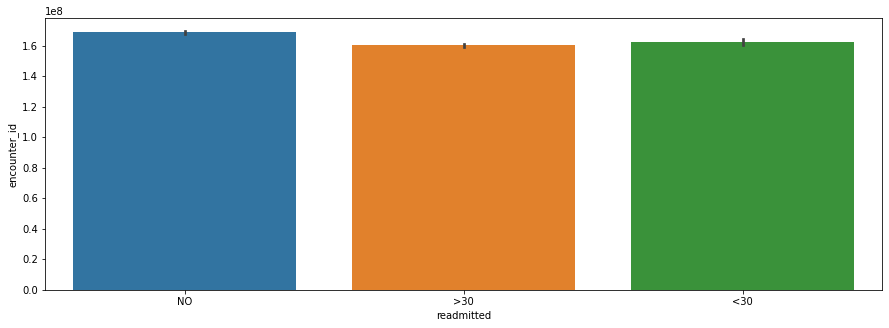

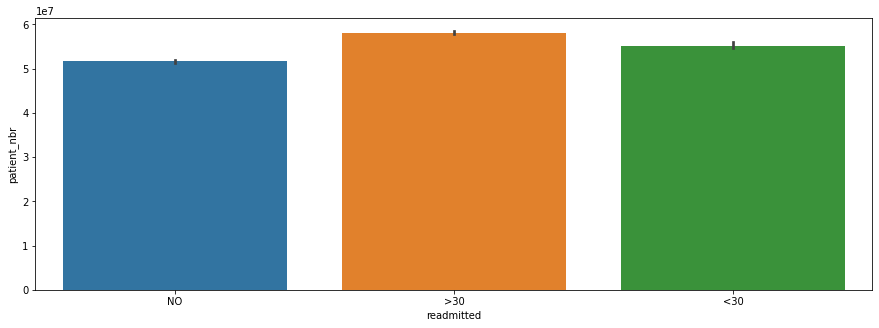

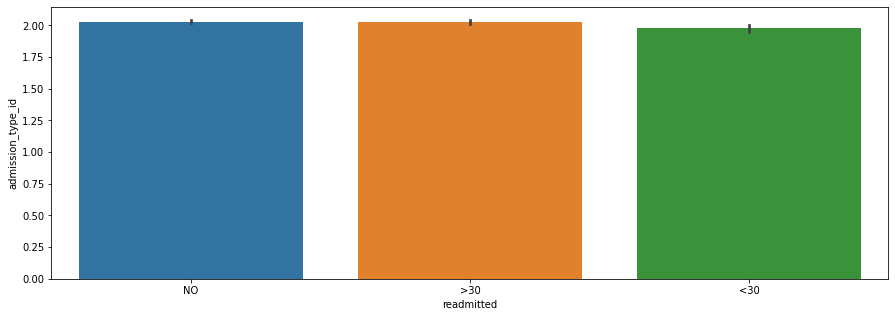

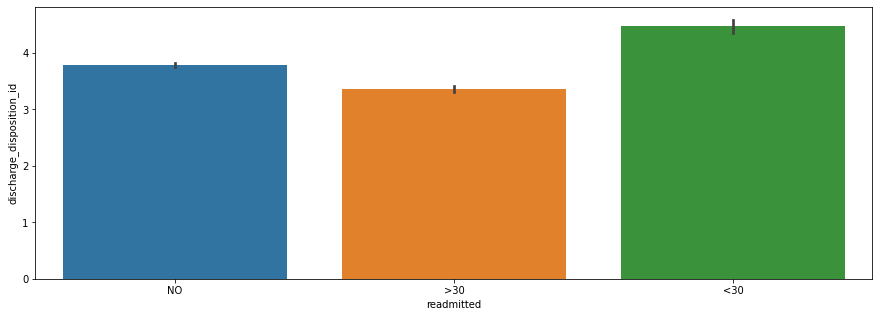

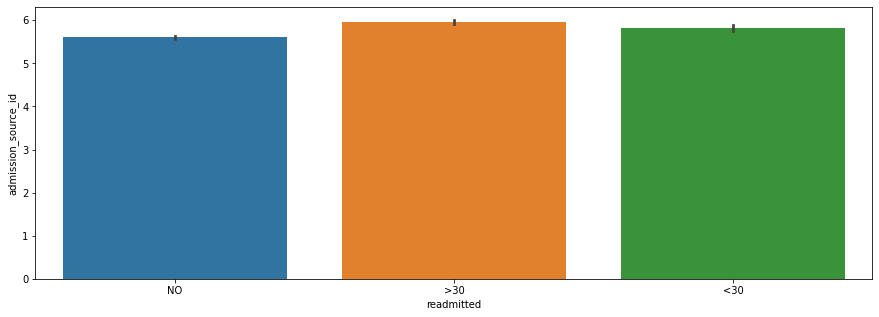

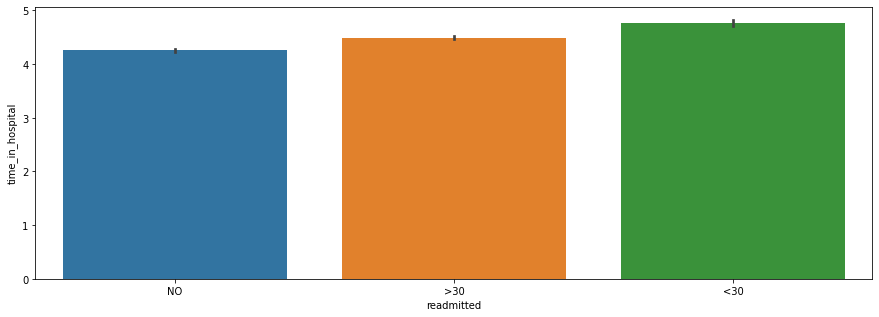

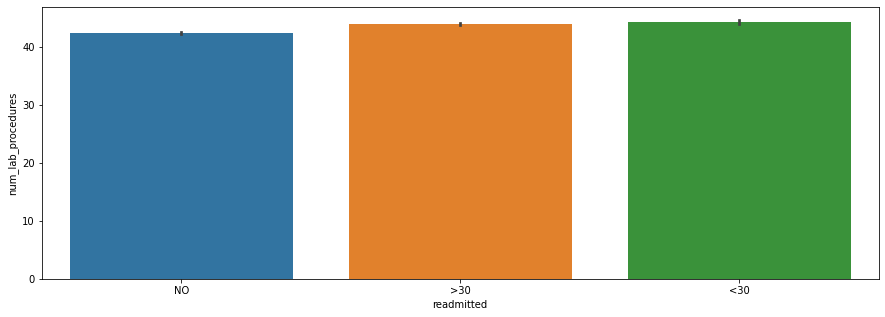

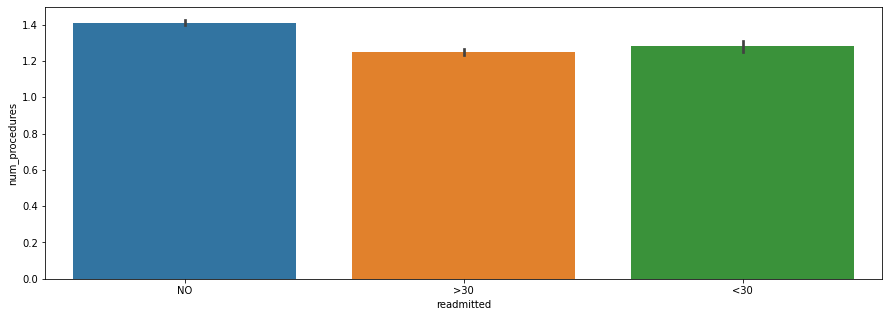

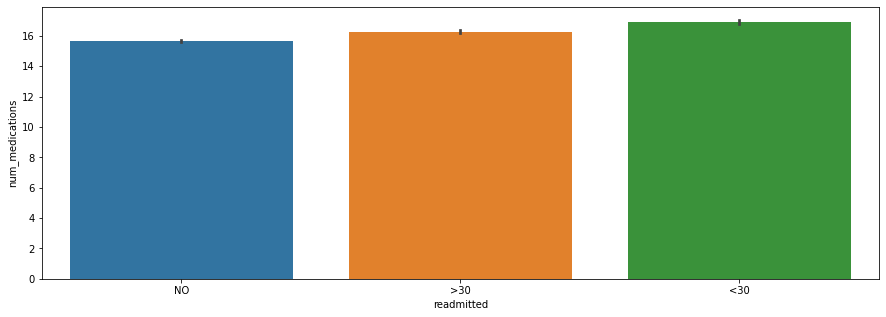

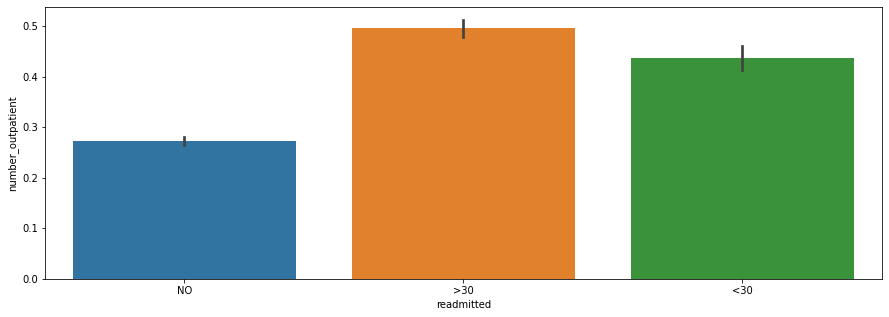

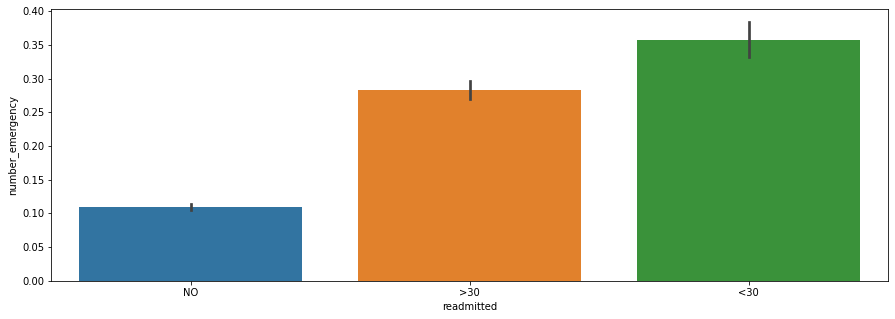

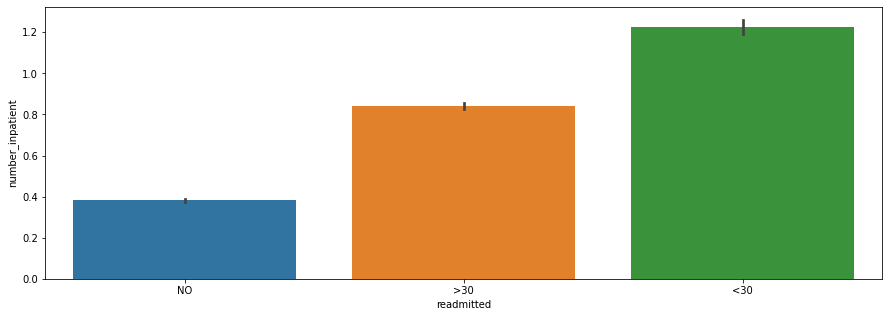

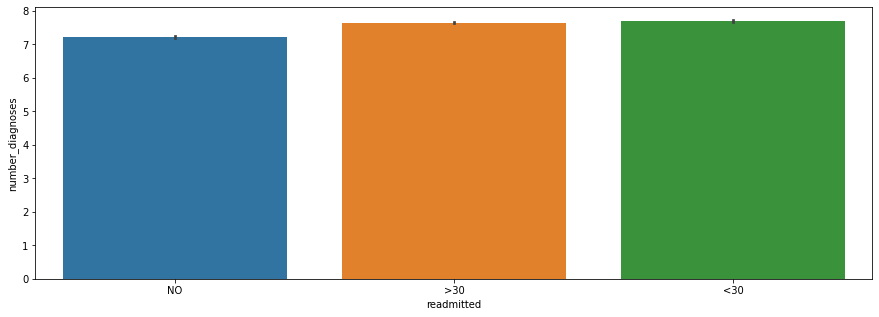

In [24]:

def barplot(df):
    for col in numeric_columns:
        plt.figure(figsize=(15,5))
        sns.barplot(data=(df.toPandas()), y=col,x='readmitted')
        plt.show()
barplot(diabetic_data)

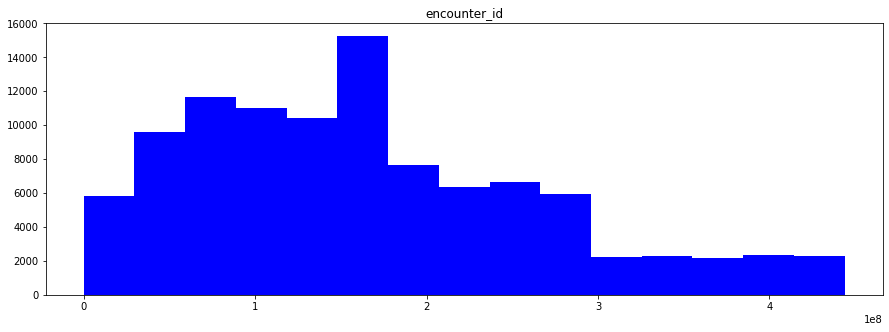

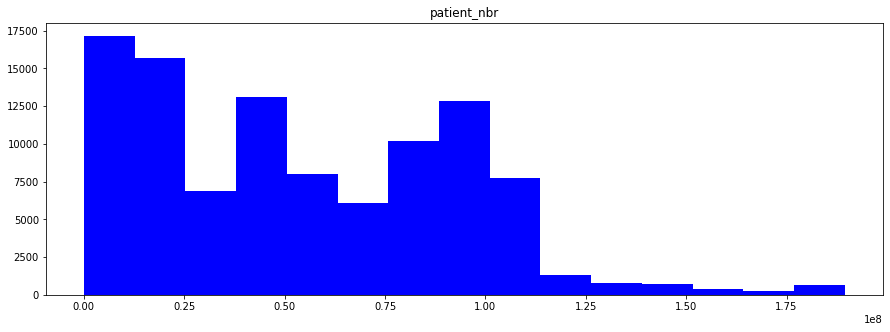

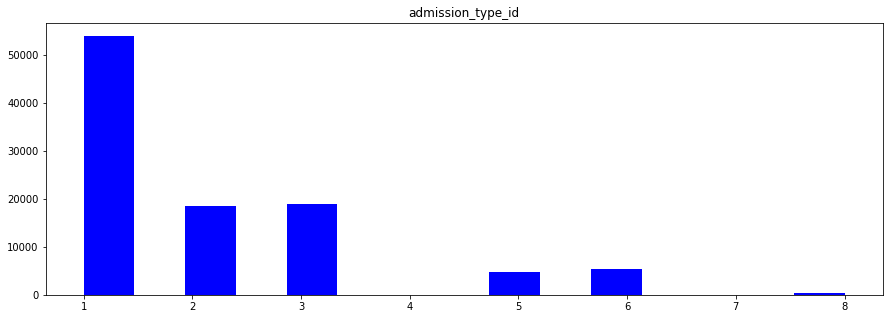

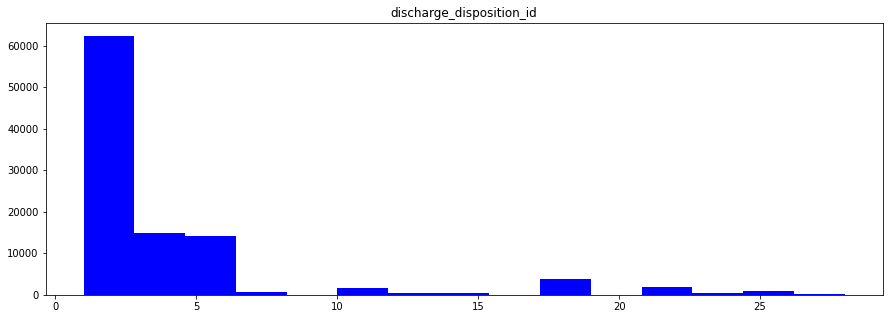

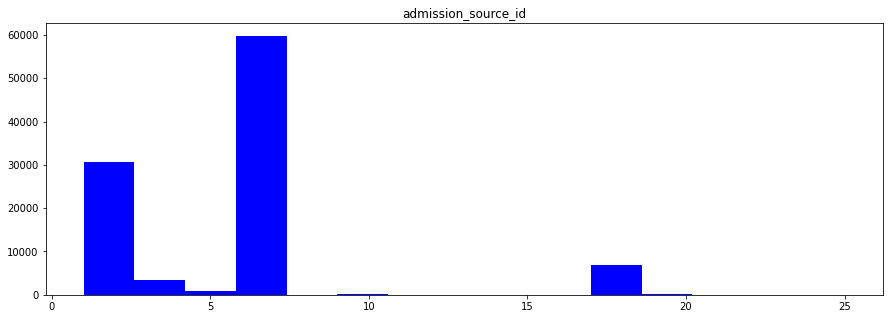

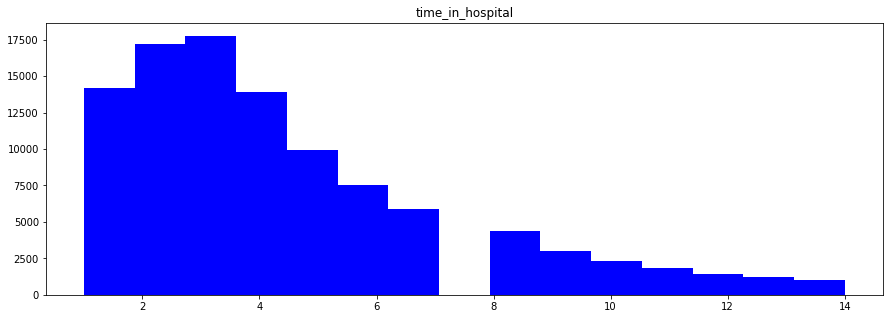

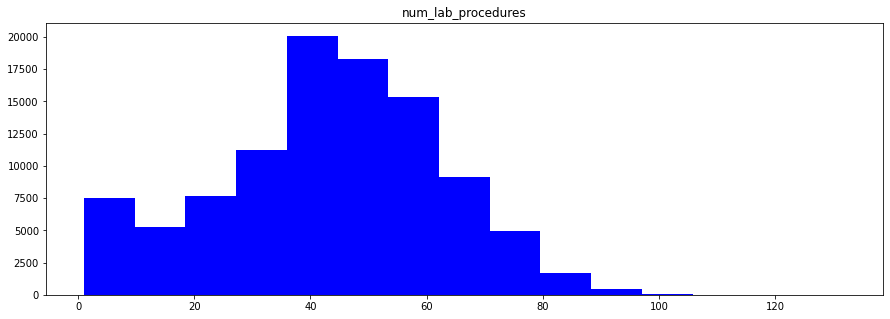

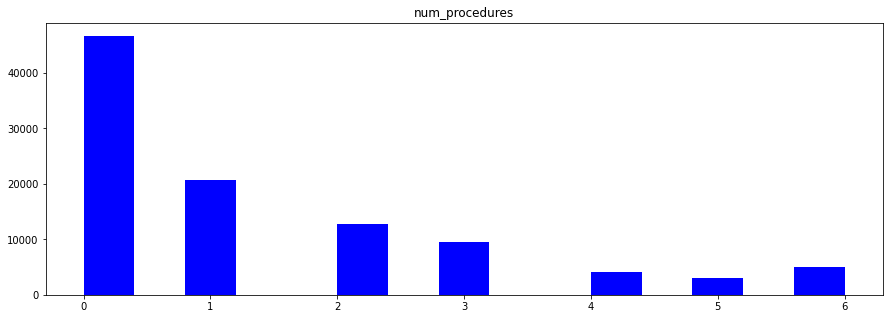

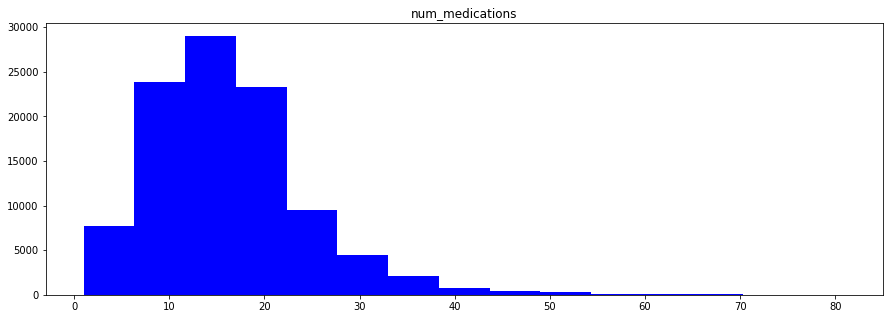

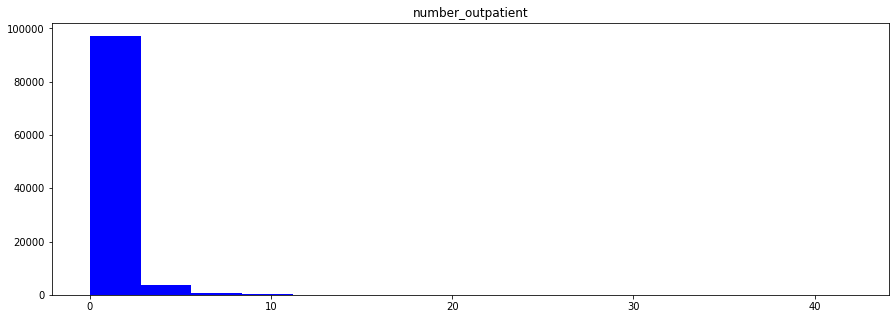

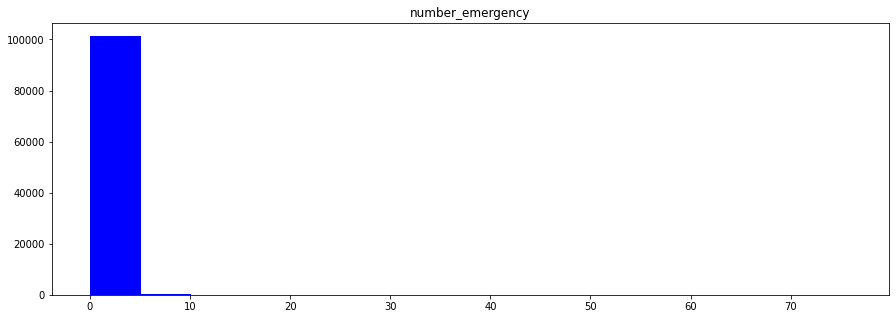

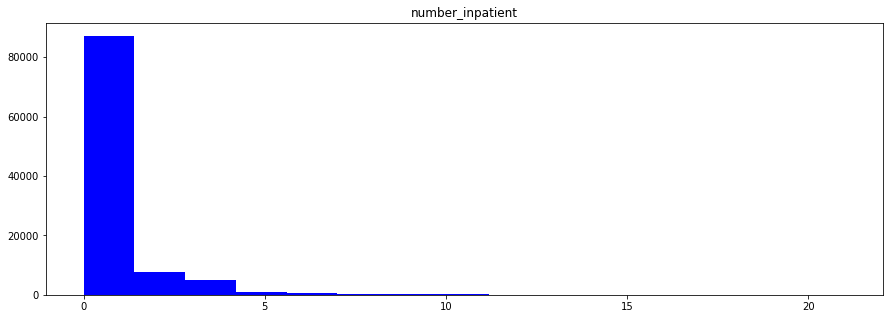

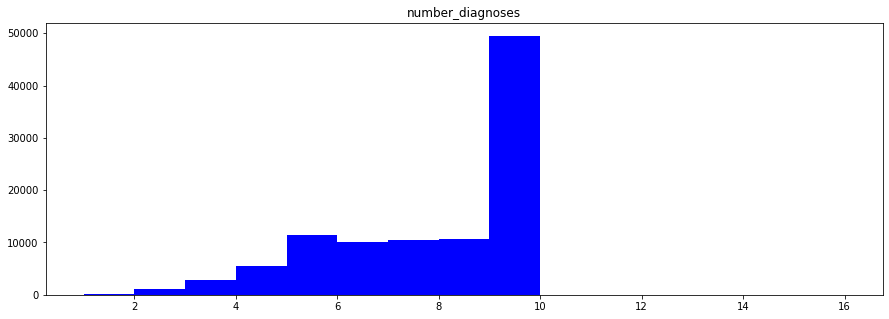

In [26]:
def histogram(df):
    for col in numeric_columns:
        plt.figure(figsize=(15,5))
        plt.hist(data=(diabetic_data.select(col).toPandas()),x=col,bins=15, color='b')
        plt.title(col)
        plt.show()
histogram(diabetic_data)

## <font color='grey'> 2.4: Data Quality</font> 

### Check Missing Values

In [27]:
# Using List comprehension, we will check the mising values in the data
from pyspark.sql.functions import col,isnan,when,count
df1 = diabetic_data.select([count(when(col(c).contains('Nan') | \
                            col(c).contains('NULL') | \
                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c), c 
                           )).alias(c)
                    for c in diabetic_data.columns])
df1.show()

#looks like data is clean but has missing values with "?" sign

+------------+-----------+----+------+---+------+-----------------+------------------------+-------------------+----------------+----------+-----------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+------+------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+----------+
|encounter_id|patient_nbr|race|gender|age|weight|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|payer_code|medical_specialty|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|diag_1|diag_2|diag_3|number_diagnoses|max_glu_serum|A1Cresult|metformin

In [28]:
# check how many columns has contained "?" sign with how many values
from pyspark.sql.functions import col,isnan,when,count
df2 = diabetic_data.select([count(when(col(c).contains('?') | \
                            isnan(c), c 
                           )).alias(c)
                    for c in diabetic_data.columns])
df2.show()

+------------+-----------+----+------+---+------+-----------------+------------------------+-------------------+----------------+----------+-----------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+------+------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+----------+
|encounter_id|patient_nbr|race|gender|age|weight|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|payer_code|medical_specialty|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|diag_1|diag_2|diag_3|number_diagnoses|max_glu_serum|A1Cresult|metformin

In [29]:
# Finding Outlier using IQR
def finding_outlier(df,col):
#     for col in numeric_columns:
    df.select(col).toPandas().astype(int)
    q1=df.approxQuantile(col,[0.25],relativeError=0)
    q3=df.approxQuantile(col,[0.75],relativeError=0)
    IQR=q3[0]-q1[0]
    upper=q3[0]+1.5*IQR
    lower=q1[0]-1.5*IQR
    df_1=df.filter((df[col]<=lower) | (df[col]>=upper) )
#         df_1=df[(df.select(col)<=lower)]
#         df_2=df[(df.select(col)>=upper)]
#     df=unionAll([df_1,df_2])

    return df_1.select(col)

In [30]:
finding_outlier(diabetic_data,'num_medications').groupby('num_medications').count().withColumnRenamed('count','outliers').sort(('num_medications')).show()

+---------------+--------+
|num_medications|outliers|
+---------------+--------+
|             35|     388|
|             36|     287|
|             37|     293|
|             38|     228|
|             39|     209|
|             40|     179|
|             41|     146|
|             42|     128|
|             43|     127|
|             44|     100|
|             45|      88|
|             46|      92|
|             47|      74|
|             48|      60|
|             49|      61|
|             50|      55|
|             51|      43|
|             52|      54|
|             53|      40|
|             54|      33|
+---------------+--------+
only showing top 20 rows



In [31]:
def outlier_count():
    for col in numeric_columns:
        print(f"{col}",finding_outlier(diabetic_data,col).count())
outlier_count()

encounter_id 0
patient_nbr 247
admission_type_id 5632
discharge_disposition_id 9818
admission_source_id 6956
time_in_hospital 3700
num_lab_procedures 171
num_procedures 8032
num_medications 2945
number_outpatient 101766
number_emergency 101766
number_inpatient 7049
number_diagnoses 281


In [32]:
from pyspark.sql.functions import col,isnan,when,count
df2 = diabetic_data.select([count(when(col(c).contains('?') | \
                            isnan(c), c 
                           )).alias(c)
                    for c in diabetic_data.columns])
df2.show()

+------------+-----------+----+------+---+------+-----------------+------------------------+-------------------+----------------+----------+-----------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+------+------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+----------+
|encounter_id|patient_nbr|race|gender|age|weight|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|payer_code|medical_specialty|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|diag_1|diag_2|diag_3|number_diagnoses|max_glu_serum|A1Cresult|metformin

In [32]:

#checked the statistics
diabetic_data.toPandas().describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.026403e+08,3.869636e+07,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.496119e+07,2.341322e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523890e+08,4.550514e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302709e+08,8.754595e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


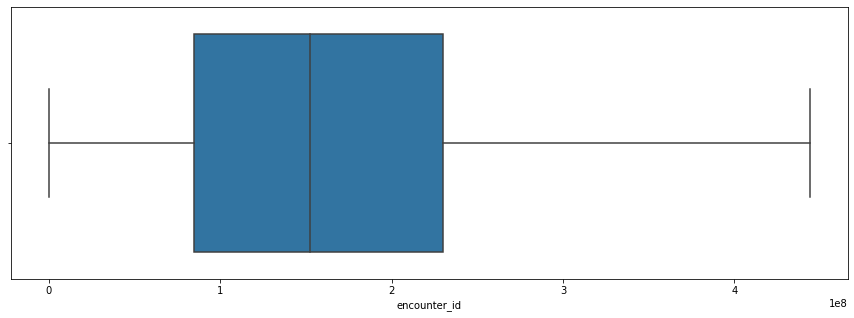

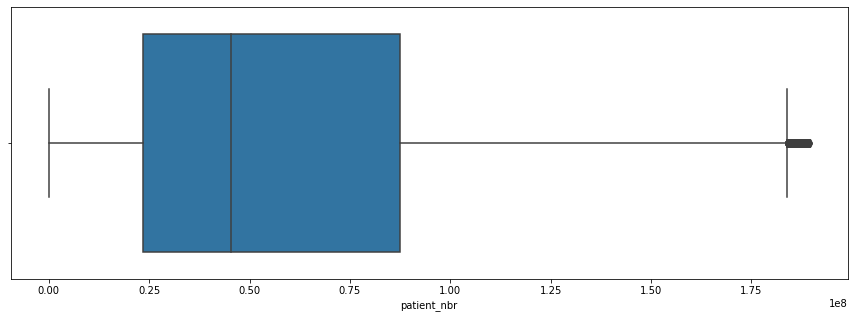

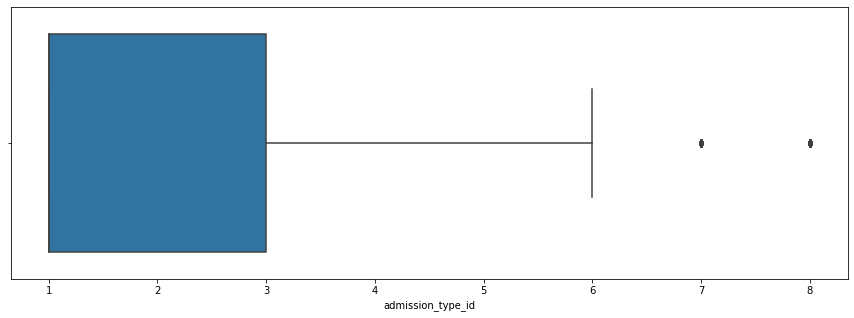

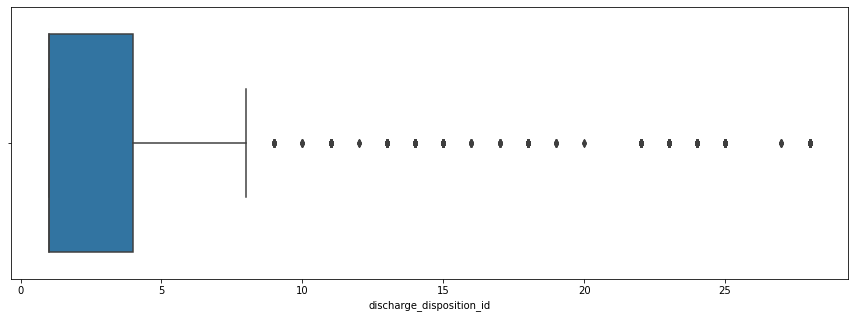

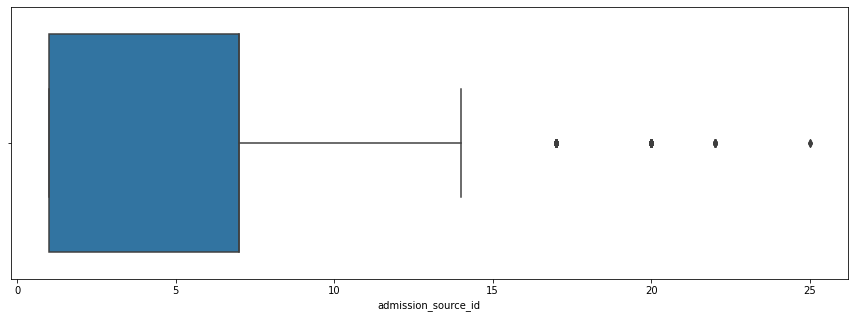

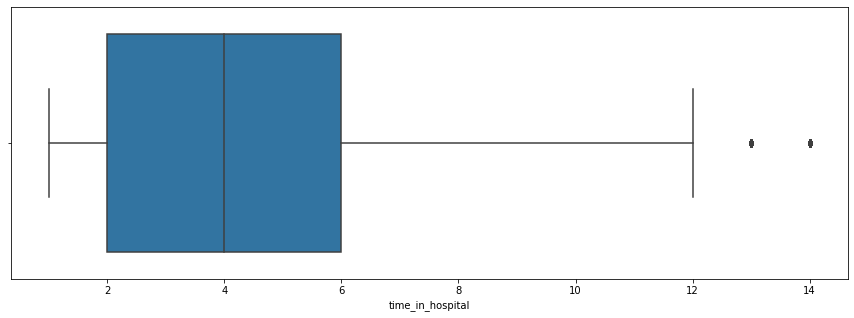

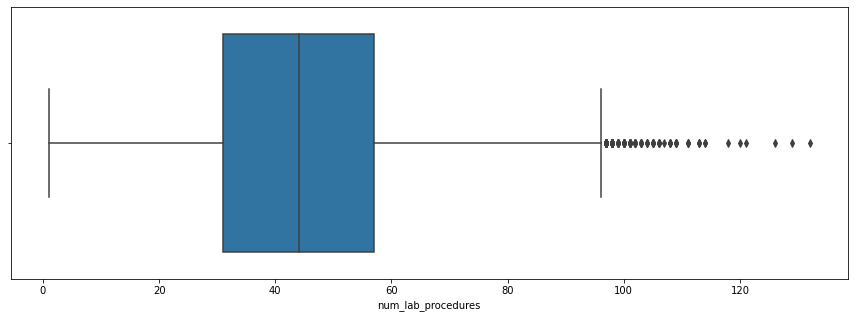

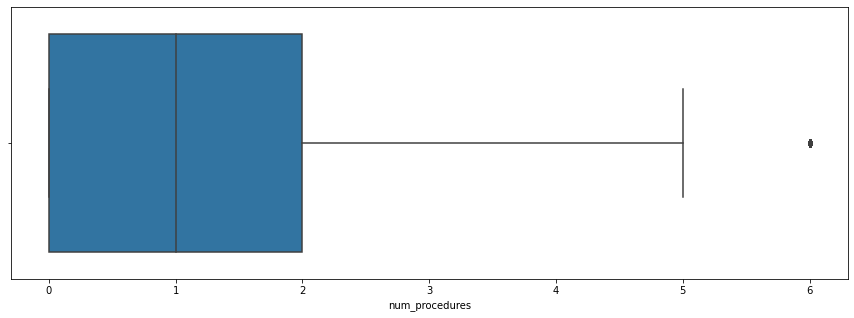

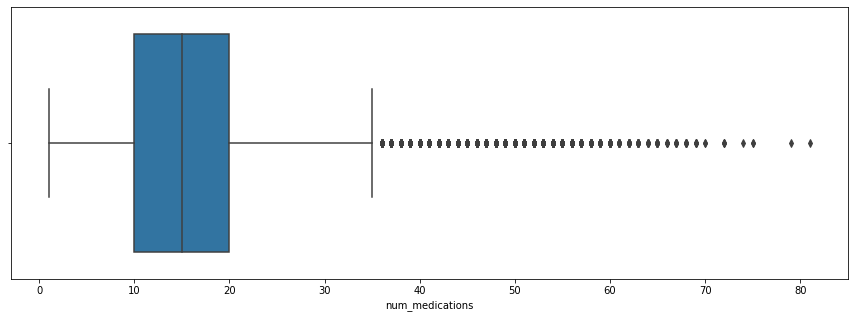

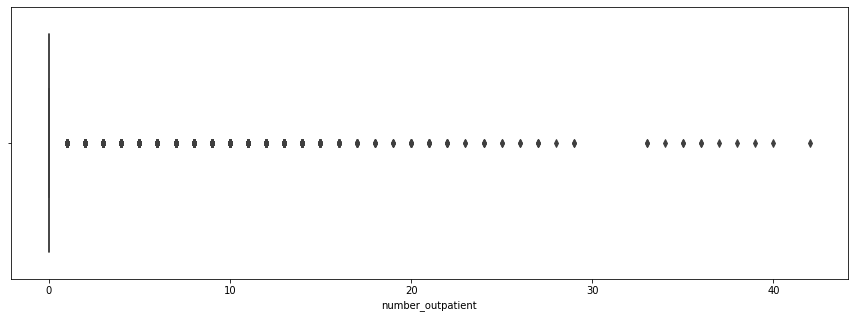

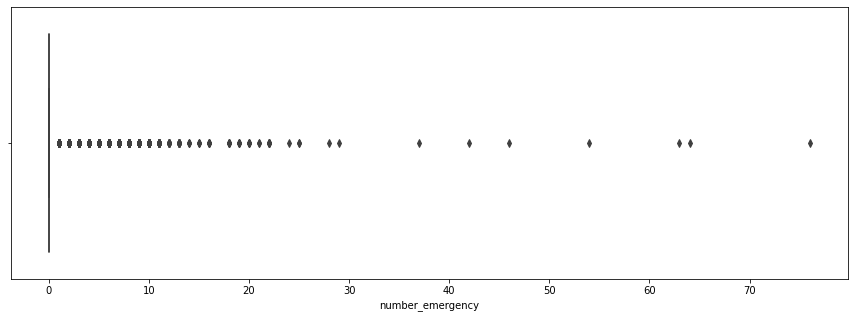

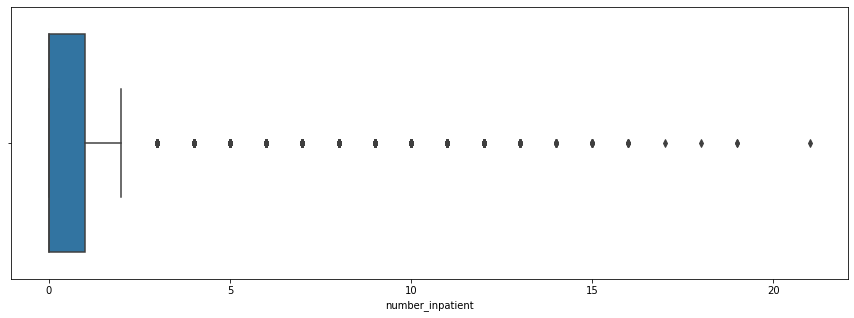

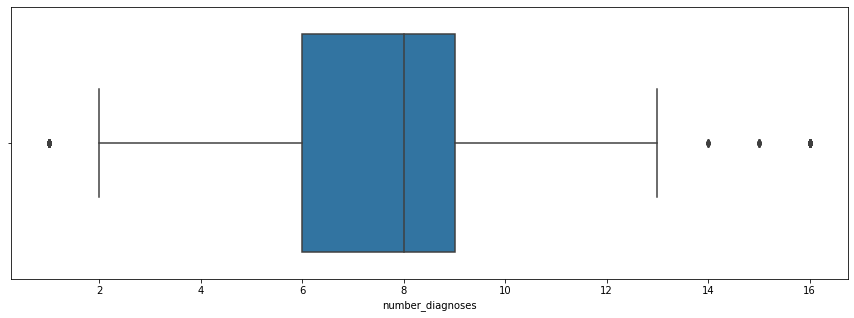

In [33]:
def boxplot(df):
    for col in numeric_columns:
        plt.figure(figsize=(15,5))
        sns.boxplot(data=(diabetic_data.select(col).toPandas()),x=col)
        plt.show()
boxplot(diabetic_data)

# <font color='orange'>Step 3: Data Preparation</font> 

## <font color='grey'> 3.1: Selecting the Data </font> 

### <font color='blue'> 3.1.1: Selecting items(rows) </font> 

In [34]:
diabetic_data.filter((diabetic_data.readmitted=='<30')).count()

11357

In [35]:
diabetic_data.select('gender').toPandas().value_counts()

gender         
Female             54708
Male               47055
Unknown/Invalid        3
dtype: int64

In [36]:
diabetic_data.filter((diabetic_data.gender=="Unknown/Invalid") & (diabetic_data.readmitted=='<30')).count()

0

In [37]:
diabetic_data=diabetic_data.filter(diabetic_data.gender!='Unknown/Invalid')
diabetic_data.select('gender').toPandas().value_counts()

gender
Female    54708
Male      47055
dtype: int64

In [38]:
diabetic_data.select('race').toPandas().value_counts()

race           
Caucasian          76099
AfricanAmerican    19210
?                   2271
Hispanic            2037
Other               1505
Asian                641
dtype: int64

In [39]:
# total 188 values of "?" in race column are contributing towards the target variable
diabetic_data.filter((diabetic_data.race=="?") & (diabetic_data.readmitted=='<30')).count()


188

In [40]:
diabetic_data=diabetic_data.filter(diabetic_data.race!='?')
diabetic_data.select('race').toPandas().value_counts()

race           
Caucasian          76099
AfricanAmerican    19210
Hispanic            2037
Other               1505
Asian                641
dtype: int64

In [41]:
# Update the readmitted column 
diabetic_data=diabetic_data.withColumn("readmitted", when(col("readmitted") == "NO",0)
      .when(col("readmitted") == "<30",1).when(col("readmitted") == ">30",0))

In [42]:
diabetic_data.select('readmitted').groupBy('readmitted').count().show()

+----------+-----+
|readmitted|count|
+----------+-----+
|         1|11169|
|         0|88323|
+----------+-----+



### <font color='blue'> 3.1.2: Selecting Attributes(Columns) </font> 

In [43]:
diabetic_data.show()

+------------+-----------+---------------+------+--------+------+-----------------+------------------------+-------------------+----------------+----------+--------------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+------+------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+----------+
|encounter_id|patient_nbr|           race|gender|     age|weight|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|payer_code|   medical_specialty|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|diag_1|diag_2|diag_3|number_diagn

In [44]:
# encounter_id & patient_nbr are just for the records purpose only. So I am deleting these attributes
# diag_1, diag_2, diag_3 have almost similar values. Hence these are correlated,we will use only the diag_1 feature.
diabetic_data=diabetic_data.drop("encounter_id","patient_nbr","diag_2","diag_3")
diabetic_data.show()

+---------------+------+--------+------+-----------------+------------------------+-------------------+----------------+----------+--------------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+----------+
|           race|gender|     age|weight|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|payer_code|   medical_specialty|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|diag_1|number_diagnoses|max_glu_serum|A1Cresult|metformin|repaglinide|nateglinide|chlorpropamide|

In [45]:
diabetic_data.show(1)

+---------+------+------+------+-----------------+------------------------+-------------------+----------------+----------+--------------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+----------+
|     race|gender|   age|weight|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|payer_code|   medical_specialty|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|diag_1|number_diagnoses|max_glu_serum|A1Cresult|metformin|repaglinide|nateglinide|chlorpropamide|glimepiride|acet

In [46]:
# Check number of rows and columns in the data after removing some attributes and records
row=diabetic_data.count()
cols=len(diabetic_data.columns)
print('Total number of columns are - ', cols)
print('\nTotal number of records are - ', row)

Total number of columns are -  46

Total number of records are -  99492


In [47]:
# update the numeric columns now
numeric_columns = [column[0] for column in diabetic_data.dtypes if column[1]=='int']

## <font color='grey'> 3.2: Clean the Data</font> 

### <font color='blue'> 3.2.1: Clean Missing Values </font> 

In [48]:

"""
As We can see in step 2.3, there is no missing values in the data, but I have found the missing values are 
imputed with "?" sign. So, First of all we will replace the "?" sign with none value. and then we will check
the missing values
"""
print(" IMPORTANT 👆👆")


 IMPORTANT 👆👆
